# Experiment: Determine relative tokenizer performance
(last updated: 2020-01-31)

## Configuration:

* Install packages for tokenizers to compare
   * pip install gensim
   * pip install nltk
   * pip install spacy
   * python -m spacy download en_core_web_sm

## Set-up:

* Find an interesting string to tokenize representative of the general data to be tokenized.
* Inspect the various tokenization options and their differences.
* Use the tokenizer benchmark results to view the expected relative performance.

In [1]:
sample_text = "@leftie This #dawg is #Boss 💯 he's a resident personality at #EsstudioGalleria he's the bestfriend of the head stylist and #founder #AleksAbadia https://t.co/qg0sRxMnHz"

## Tokenizers:

* Python str.split()
   * Split the string on spaces as a benchmark

In [2]:
def build_df(lists, columns):
    maxlen = max(len(x) for x in lists)
    for x in lists:
        x.extend(['']*(maxlen-len(x)))
    return pd.DataFrame(zip(*lists), columns=columns)

toks = list()
names = list()

import pandas as pd
str_split = sample_text.split()
toks.append(str_split)
names.append('split()')
pd.DataFrame(str_split)

,0
0,@leftie
1,This
2,#dawg
3,is
4,#Boss
5,💯
6,he's
7,a
8,resident
9,personality


* Regex
   * The "regex" tokenizer splits on symbols and whitespace

In [3]:
import re
split_re = re.compile(r'[\W]+')
re_split = split_re.split(sample_text)
toks.append(re_split)
names.append('re.split()')
pd.DataFrame(re_split)

,0
0,
1,leftie
2,This
3,dawg
4,is
5,Boss
6,he
7,s
8,a
9,resident


* LaTok -- Linear Algebraic Tokenizer Splitting Cores and Options
   * SIMPLE_SMG -- Splits on whitespace and symbols
   * GENERAL_SMG -- Splits words including camel case, keeping together emails, urls, numeric sequences, and words with embedded apostrophes
   * TWEET_SMG -- Splits words, keeping together all GENERAL_SMG and twitter special sequences
   * MENTION_SMG -- Similar to TWEET_SMG, but only preserves twitter mention sequences. Hashtags will be broken into tokens.

In [4]:
import latok.core.constants as C
import latok.core.general_cores as general_cores
import latok.core.split_mask_generator as split_mask_generator
import latok.core.tokenizer as latok
import latok.core.twitter_cores as twitter_cores

simple_smg_splitter = latok.Splitter(split_mask_generator.SIMPLE_SMG)
smg_split = list(simple_smg_splitter.split(sample_text))

general_smg_splitter = latok.Splitter(general_cores.build_general_split_mask_generator())
gen_split = list(general_smg_splitter.split(sample_text))

general_smg_tokenizer = latok.Tokenizer(general_cores.build_general_split_mask_generator())
gen_tok = list(general_smg_tokenizer.tokenize(sample_text))

general_smg_tokenizer_with_options = latok.Tokenizer(
    smg=general_cores.build_general_split_mask_generator(),
    specs_and_repls=[
        (C.EMAIL_FEATURE, '_EMAIL'),
        (C.URL_FEATURE, '_URL'),
        (C.NUMERIC_FEATURE, '_NUM'),
    ],
    to_lower=True,
    drop_symbols=True,
    keep_emojis=False)
gen_tok_wopts = list(general_smg_tokenizer_with_options.tokenize(sample_text))

tweet_smg_tokenizer = latok.Tokenizer(
    smg=twitter_cores.TWEET_SMG,
    specs_and_repls=[
        (C.TWITTER_MENTION_FEATURE, '_MENTION'),
        (C.TWITTER_HASHTAG_FEATURE, '_HASHTAG'),
        (C.EMAIL_FEATURE, '_EMAIL'),
        (C.URL_FEATURE, '_URL'),
        (C.NUMERIC_FEATURE, '_NUM'),
    ],
    to_lower=False,
    drop_symbols=True,
    keep_emojis=True
)
tweet_tok = list(tweet_smg_tokenizer.tokenize(sample_text))

mention_smg_tokenizer = latok.Tokenizer(
    smg=twitter_cores.MENTION_SMG,
    specs_and_repls=[
        (C.TWITTER_MENTION_FEATURE, '_MENTION'),
        (C.EMAIL_FEATURE, '_EMAIL'),
        (C.URL_FEATURE, '_URL'),
        (C.NUMERIC_FEATURE, '_NUM'),
    ],
    to_lower=False,
    drop_symbols=True,
    keep_emojis=True
)
mention_tok = list(mention_smg_tokenizer.tokenize(sample_text))

latok_toks = [smg_split, gen_split, gen_tok, gen_tok_wopts, tweet_tok, mention_tok]
latok_names = ['SIMPLE_SMG_SPLIT', 'GEN_SMG_SPLIT', 'GEN_SMG_TOK', 'GEN_SMG_WOPTS', 'TWEET_TOK', 'MENTION_TOK']
toks.extend(latok_toks)
names.extend(latok_names)

build_df(latok_toks, latok_names)

,SIMPLE_SMG_SPLIT,GEN_SMG_SPLIT,GEN_SMG_TOK,GEN_SMG_WOPTS,TWEET_TOK,MENTION_TOK
0,@,@,@,leftie,_MENTION,_MENTION
1,leftie,leftie,leftie,this,This,This
2,This,This,This,dawg,_HASHTAG,dawg
3,#,#,#,is,is,is
4,dawg,dawg,dawg,boss,_HASHTAG,Boss
5,is,is,is,he's,💯,💯
6,#,#,#,a,he's,he's
7,Boss,Boss,Boss,resident,a,a
8,💯,💯,💯,personality,resident,resident
9,he,he's,he's,at,personality,personality


* NLTK
   * Of the variety of tokenizers available for use with nltk, analyzing:
      * wordpunct_tokenize -- Split on whitespace and word punctuation
      * word_tokenize -- Split on words

In [5]:
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download('punkt')
nltk_word_tok = word_tokenize(sample_text)
nltk_wordpunct_tok = wordpunct_tokenize(sample_text)
nltk_toks = [nltk_word_tok, nltk_wordpunct_tok]
nltk_names = ['nltk_word', 'nltk_wordpunct']
toks.extend(nltk_toks)
names.extend(nltk_names)
build_df(nltk_toks, nltk_names)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,nltk_word,nltk_wordpunct
0,@,@
1,leftie,leftie
2,This,This
3,#,#
4,dawg,dawg
5,is,is
6,#,#
7,Boss,Boss
8,💯,💯
9,he,he


* gensim
   * Gensim's tokenization appears to split on both space and symbols
      * But still needs to be investigated for better tunability

In [6]:
import gensim
gensim_tok = list(gensim.utils.tokenize(sample_text))
toks.append(gensim_tok)
names.append('gensim')
pd.DataFrame(gensim_tok)

,0
0,leftie
1,This
2,dawg
3,is
4,Boss
5,he
6,s
7,a
8,resident
9,personality


* Spacy
   * oob: Out of the box does a lot more work than other parsers, so 229/sec is not a fair comparison
   * slim: With extra functionality disabled, performs better
      * and will likely perform much better when its batch mode is used

In [7]:
import spacy
nlp_slow = spacy.load('en_core_web_sm')
nlp_fast = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
spacy_slow_tok = list(nlp_slow(sample_text))
spacy_fast_tok = list(nlp_fast(sample_text))
spacy_toks = [spacy_slow_tok, spacy_fast_tok]
spacy_names = ['spacy_slow', 'spacy_fast']
toks.extend(spacy_toks)
names.extend(spacy_names)
build_df(spacy_toks, spacy_names)

,spacy_slow,spacy_fast
0,@leftie,@leftie
1,This,This
2,#,#
3,dawg,dawg
4,is,is
5,#,#
6,Boss,Boss
7,💯,💯
8,he,he
9,'s,'s


### Tokenization Summary:

In [8]:
build_df(toks, names)

,split(),re.split(),SIMPLE_SMG_SPLIT,GEN_SMG_SPLIT,GEN_SMG_TOK,GEN_SMG_WOPTS,TWEET_TOK,MENTION_TOK,nltk_word,nltk_wordpunct,gensim,spacy_slow,spacy_fast
0,@leftie,,@,@,@,leftie,_MENTION,_MENTION,@,@,leftie,@leftie,@leftie
1,This,leftie,leftie,leftie,leftie,this,This,This,leftie,leftie,This,This,This
2,#dawg,This,This,This,This,dawg,_HASHTAG,dawg,This,This,dawg,#,#
3,is,dawg,#,#,#,is,is,is,#,#,is,dawg,dawg
4,#Boss,is,dawg,dawg,dawg,boss,_HASHTAG,Boss,dawg,dawg,Boss,is,is
5,💯,Boss,is,is,is,he's,💯,💯,is,is,he,#,#
6,he's,he,#,#,#,a,he's,he's,#,#,s,Boss,Boss
7,a,s,Boss,Boss,Boss,resident,a,a,Boss,Boss,a,💯,💯
8,resident,a,💯,💯,💯,personality,resident,resident,💯,💯,resident,he,he
9,personality,resident,he,he's,he's,at,personality,personality,he,he,personality,'s,'s


# Benchmarking

In [9]:
import latok.util.benchmark as benchmark

# Parameters: (configure as desired)
max_iters = 10000
max_seconds = 10
min_report_count = 10001

# Run benchmarks
benchmark_data = list()
benchmark_cols = ['tokenizer', 'rate/sec', 'count', 'seconds', 'description']
corpus = sample_text * max_iters

def run_benchmark(function, long_description, short_name):
    print(f'Starting benchmark: {long_description}')
    count, seconds = benchmark.benchmark(
        function, corpus,
        max_iters=max_iters,
        max_seconds=max_seconds,
        min_report_count=min_report_count)
    return (short_name, round(count/seconds, 2), count, seconds, long_description)

## Run the benchmarking

In [10]:
benchmark_data.append(run_benchmark(
    lambda x: x.split(),
    'python string split',
    'split'
))
benchmark_data.append(run_benchmark(
    lambda x: split_re.split(x),
    'regex: "{split_re.pattern}"',
    'regex'
))
benchmark_data.append(run_benchmark(
    lambda x: list(simple_smg_splitter.split(x)),
    'latok simple split',
    'LATOK-simple-split'
))
benchmark_data.append(run_benchmark(
    lambda x: list(general_smg_splitter.split(x)),
    'latok general split',
    'LATOK-general-split'
))
benchmark_data.append(run_benchmark(
    lambda x: list(general_smg_tokenizer.tokenize(x)),
    'latok general tokenize',
    'LATOK-general-tok'
))
benchmark_data.append(run_benchmark(
    lambda x: list(general_smg_tokenizer_with_options.tokenize(x)),
    'latok general tokenize with options',
    'LATOK-general-tok-wopt'
))
benchmark_data.append(run_benchmark(
    lambda x: list(tweet_smg_tokenizer.tokenize(x)),
    'latok tweet tokenize with options',
    'LATOK-tweet-tok'
))
benchmark_data.append(run_benchmark(
    lambda x: list(mention_smg_tokenizer.tokenize(x)),
    'latok mention tokenize with options',
    'LATOK-mention-tok'
))
benchmark_data.append(run_benchmark(
    lambda x: word_tokenize(x),
    'nltk word tokenize',
    'nltk-word'
))
benchmark_data.append(run_benchmark(
    lambda x: wordpunct_tokenize(x),
    'nltk wordpunct tokenize',
    'nltk-wordpunct'
))
benchmark_data.append(run_benchmark(
    lambda x: list(gensim.utils.tokenize(x)),
    'gensim tokenize',
    'gensim'
))
benchmark_data.append(run_benchmark(
    lambda x: list(nlp_slow(x)),
    'spacy slow tokenize',
    'spacy-slow'
))
benchmark_data.append(run_benchmark(
    lambda x: list(nlp_fast(x)),
    'spacy fast tokenize',
    'spacy-fast'
))

Starting benchmark: python string split
2020-01-31 22:08:43.357888: processed 10001 items @ 57504.1111/sec in 0:00:00.173918
Starting benchmark: regex: "{split_re.pattern}"
2020-01-31 22:08:43.549933: processed 10001 items @ 52540.3338/sec in 0:00:00.190349
Starting benchmark: latok simple split
2020-01-31 22:08:43.928535: processed 10001 items @ 26495.0314/sec in 0:00:00.377467
Starting benchmark: latok general split
2020-01-31 22:08:45.369455: processed 10001 items @ 6947.9905/sec in 0:00:01.439409
Starting benchmark: latok general tokenize
2020-01-31 22:08:46.818936: processed 10001 items @ 6906.0812/sec in 0:00:01.448144
Starting benchmark: latok general tokenize with options
2020-01-31 22:08:48.801427: processed 10001 items @ 5050.8137/sec in 0:00:01.980077
Starting benchmark: latok tweet tokenize with options
2020-01-31 22:08:50.962579: processed 10001 items @ 4632.0698/sec in 0:00:02.159078
Starting benchmark: latok mention tokenize with options
2020-01-31 22:08:53.042564: proce

## Benchmark Results:

In [11]:
bdf = pd.DataFrame(benchmark_data, columns=benchmark_cols)
bdf.sort_values('rate/sec', ascending=False, inplace=True)
bdf

,tokenizer,rate/sec,count,seconds,description
0,split,57507.29,10000,0.173891,python string split
1,regex,52540.60,10000,0.190329,"regex: ""{split_re.pattern}"""
9,nltk-wordpunct,50301.81,10000,0.198800,nltk wordpunct tokenize
10,gensim,39466.73,10000,0.253378,gensim tokenize
2,LATOK-simple-split,26493.79,10000,0.377447,latok simple split
12,spacy-fast,21600.09,10000,0.462961,spacy fast tokenize
8,nltk-word,8430.15,10000,1.186219,nltk word tokenize
3,LATOK-general-split,6947.38,10000,1.439391,latok general split
4,LATOK-general-tok,6905.49,10000,1.448123,latok general tokenize
5,LATOK-general-tok-wopt,5050.35,10000,1.980059,latok general tokenize with options


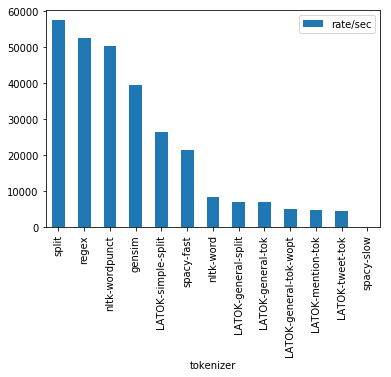

In [12]:
%matplotlib inline
bdf.plot.bar(x='tokenizer', y='rate/sec')

### Addendum

The following table is included for the sake of interest and recording effects of optimization techniques tried during early latok development.

The gist of the results is that python style differences do matter in small degrees for overall performance, but c-extensions do have a dramatic effect.

In [13]:
data2 = [
    ('pure-python-original', 1625.62, 'unoptimized proof of concept'),
    ('pure-python-optimized-01', 2230.65, 'transpose matrix for row access after build'),
    ('pure-python-optimized-02', 2498.44, 'pre-compute rolling features'),
    ('pure-python-optimized-03', 2502.59, 'use set instead of string for twitter specials'),
    ('pure-python-optimized-04', 2524.06, "don't set vars for unused/unneeded rows"),
    ('pure-python-optimized-05', 2577.46, 'use np.flat(iter) for for loop'),
    ('pure-python-optimized-06', 2608.76, 'combine block masks for one call'),
    ('pure-python-optimized-07', 2628.88, 'change "&", "|" to "*", "+"'),
    ('pure-python-optimized-08', 2652.68, 'manually create idx counter instead of using enumerate'),
    ('pure-python-optimized-09', 3346.93, "don't do ternary variable sets, only set a value if needed"),
    ('pure-python-optimized-10', 3577.66, 'use function local instead of class variable references'),
    ('pure-python-optimized-11', 4309.94, 'use generator; use "strip" instead of list comprehension'),
    ('c-ext-gen-parse-matrix', 11582.94, 'c-extension to generate feature matrix'),
    ('c-ext-gen-block-mask', 15750.75, 'c-extension to generate block mask'),
    ('c-ext-combine-matrix-rows', 25270.85, 'c-extension to combine matrix rows'),
]

df2 = pd.DataFrame(data2)
df2.columns = ['version', 'rate/sec', 'description']
df2.sort_values('rate/sec', ascending=True, inplace=True)
df2

,version,rate/sec,description
0,pure-python-original,1625.62,unoptimized proof of concept
1,pure-python-optimized-01,2230.65,transpose matrix for row access after build
2,pure-python-optimized-02,2498.44,pre-compute rolling features
3,pure-python-optimized-03,2502.59,use set instead of string for twitter specials
4,pure-python-optimized-04,2524.06,don't set vars for unused/unneeded rows
5,pure-python-optimized-05,2577.46,use np.flat(iter) for for loop
6,pure-python-optimized-06,2608.76,combine block masks for one call
7,pure-python-optimized-07,2628.88,"change ""&"", ""|"" to ""*"", ""+"""
8,pure-python-optimized-08,2652.68,manually create idx counter instead of using e...
9,pure-python-optimized-09,3346.93,"don't do ternary variable sets, only set a val..."


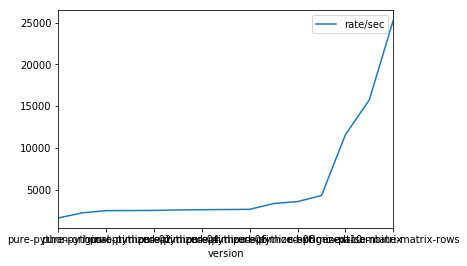

In [14]:
df2.plot(x='version', y='rate/sec')